In [1]:
from ipywidgets import IntProgress
from IPython.display import display
import time

from covid19_vulnerabilidad_mex.datos import *
from covid19_vulnerabilidad_mex.vulnerabilidad import *

import pandas as pd
import geopandas as gpd

import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

from datetime import timedelta
import datetime
from datetime import timedelta, date, datetime
import pickle

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_decomposition import PLSRegression

import seaborn as sns
import imageio
from pygifsicle import optimize

plt.style.use('ggplot')

In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
antier = date.today() - timedelta(days=2)
fecha_analisis = antier - timedelta(weeks=2)
fecha_analisis = pd.to_datetime(fecha_analisis)
metodo = 'PLS'
ventana_dias = 28
inicio = pd.to_datetime('20-03-15', yearfirst=True)
fin = antier - timedelta(days=7)
actualizar_datos_salud(fecha_inicio='18-02-2021')

Bajando datos 08.03.2021


In [3]:
serie_municipal = pickle.load( open( "datos/serie_municipal_reclasificada_9-03-21.pkl", "rb" ) )

In [4]:
modelos, serie = periodo_vulnerabilidad_con_dataframe(
            serie_municipal,
            inicio,
            fin,
            min_casos=10,
            columna='covid_defun_100k',
            rf=False
        )
serie = agregar_vulnerabilidad_entidades(serie, 'valor_covid_defun_100k')

IntProgress(value=0, max=351)

<AxesSubplot:xlabel='FECHA_INGRESO', ylabel='valor_covid_defun_100k'>

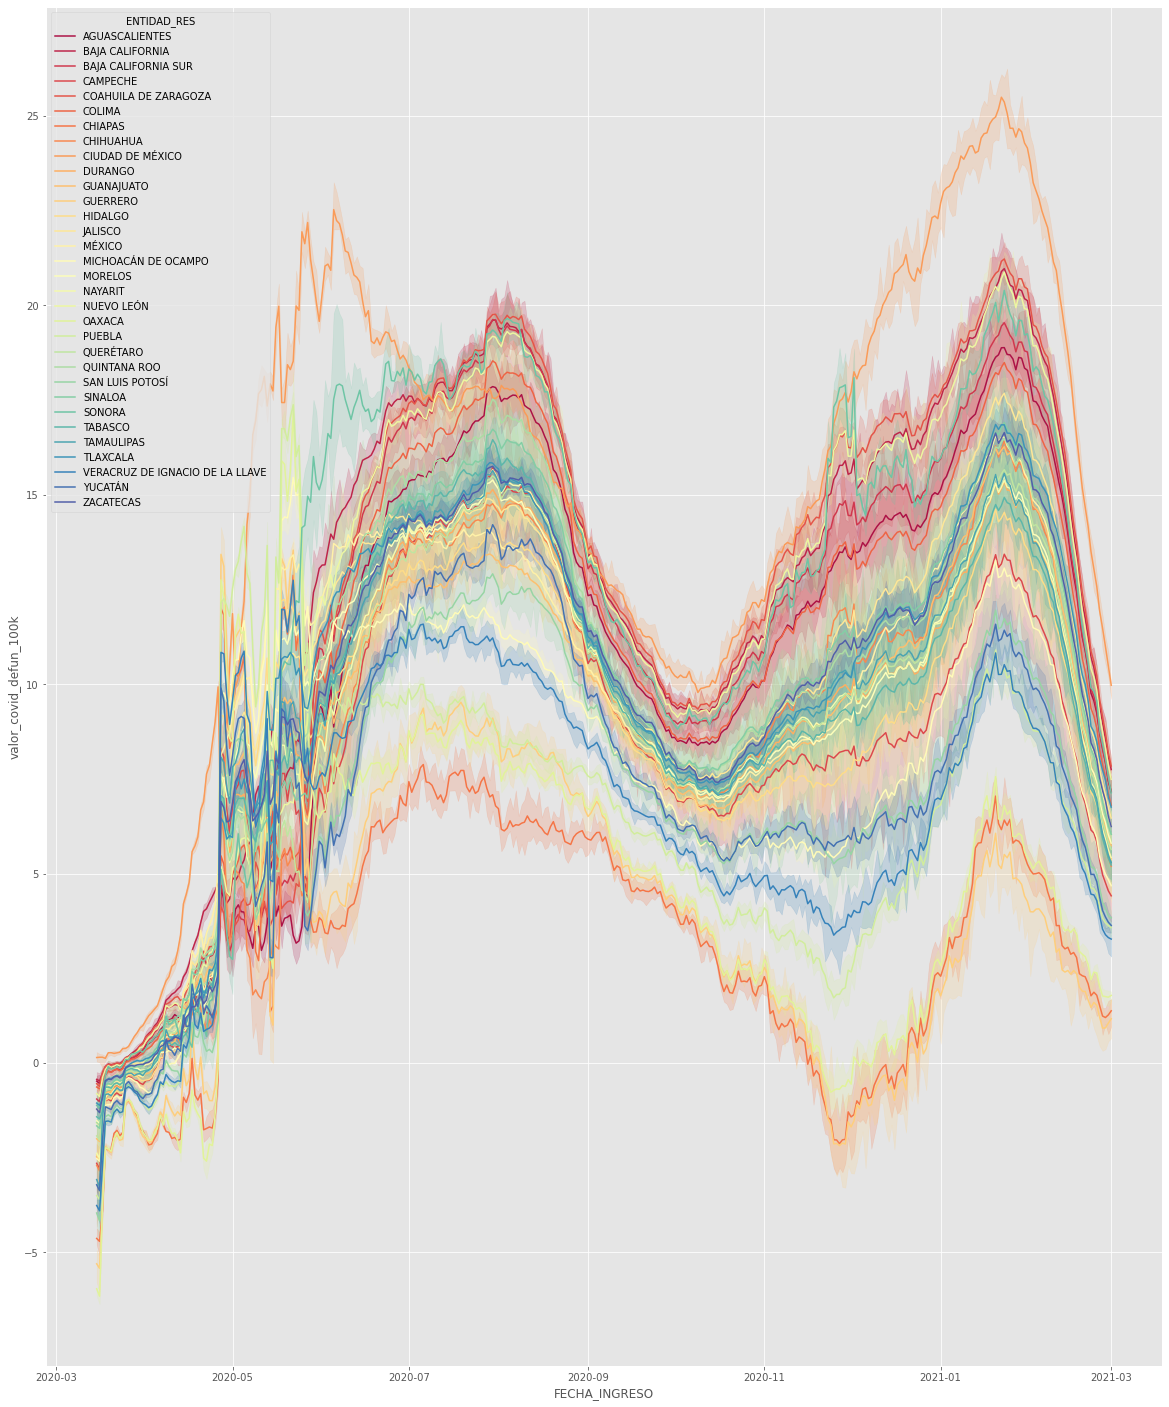

In [5]:
fig, ax = plt.subplots(figsize=(20, 25))
sns.lineplot(data=serie,
             x='FECHA_INGRESO', y=f'valor_covid_defun_100k',
             hue='ENTIDAD_RES', palette='Spectral',
             n_boot=10)

# Análisis temporal

Con las series de vulnerabilidad y modelos ajustadas al 9 de marzo vamos a hacer un análisis de la variación temporal de la vulnerabilidad. El análisisis se va a centrar en dos ideas:

* ¿Cómo cambia la vulnerabilidad relativa de estados y municipios en el tiempo?
* ¿Cómo cambia la importancia relativa de los parámetros?

Como primera aproximación, en lugar de comparar las series de tiempo completas, vamos a utilizar cortes de tiempo definidos a partir de momentos importantes en la pandemia:

* Antes del inicio de la jornada de sana distancia (23 de marzo 2020)
* A la mitad de la jornada (30 de abril)
* Al finalizar la jornada (30 de mayo)
* Alrededor del pico de casos (1 de agosto)
* En el punto más bajo (15 de octubre)
* A mitad del camino entre este punto y el segundo pico (1 de diciembre)
* En el segundo pico (20 de enero de 2021)
* Actualmente (9 de marzo)

In [6]:
fechas = [pd.to_datetime('20-03-23', yearfirst=True),
          pd.to_datetime('20-04-30', yearfirst=True),
          pd.to_datetime('20-05-30', yearfirst=True),
          pd.to_datetime('20-08-01', yearfirst=True),
          pd.to_datetime('20-10-15', yearfirst=True),
          pd.to_datetime('20-12-01', yearfirst=True),
          pd.to_datetime('21-01-20', yearfirst=True),
          pd.to_datetime('21-03-08', yearfirst=True),]

In [7]:
serie_momentos = serie[serie.FECHA_INGRESO.isin(fechas)]
modelos_momentos = modelos[modelos.dia_ajuste.isin(fechas)]

## Evolución de la vulnerabilidad por estado

Para entender la evolución de la vulonerabilidad a nivel estatal vamos a graficar la dinámica del ranking de vulnerabilidad sobre los estados

<AxesSubplot:xlabel='FECHA_INGRESO', ylabel='valor_covid_defun_100k_entidad'>

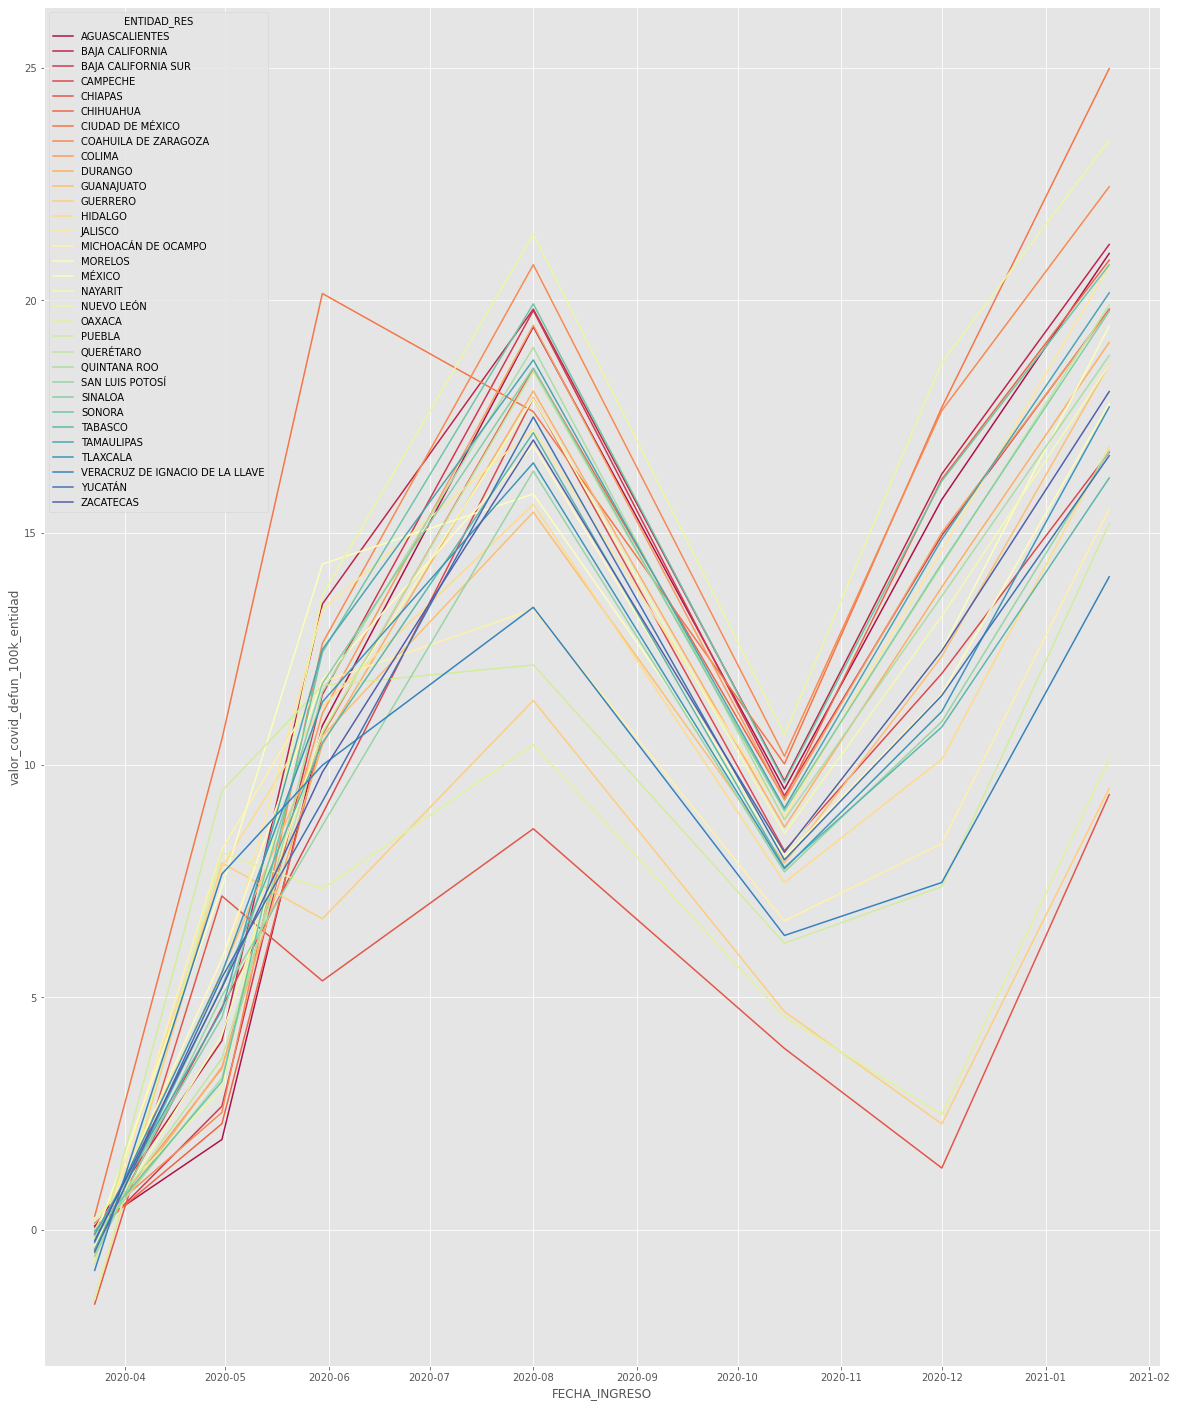

In [8]:
entidad_momentos = (serie_momentos[["ENTIDAD_RES", "FECHA_INGRESO", "valor_covid_defun_100k_entidad"]]
                    .groupby(["ENTIDAD_RES", "FECHA_INGRESO"])['valor_covid_defun_100k_entidad']
                    .mean()
                    .reset_index()
                    )
fig, ax = plt.subplots(figsize=(20, 25))
sns.lineplot(data=entidad_momentos,
             x='FECHA_INGRESO', y=f'valor_covid_defun_100k_entidad',
             hue='ENTIDAD_RES', palette='Spectral')

In [9]:
entidad_momentos = (entidad_momentos
                    .pivot(index='ENTIDAD_RES', 
                          columns='FECHA_INGRESO', 
                          values='valor_covid_defun_100k_entidad')
                )
ranking_entidades = entidad_momentos.rank(ascending=False)
new_cols = [c.strftime('%Y-%m-%d') if isinstance(c, datetime) else c for c in ranking_entidades.reset_index().columns]
parallel_data = ranking_entidades.reset_index()
parallel_data.columns = new_cols

In [10]:
fig, ax = plt.subplots(figsize=(20, 15))
p = pd.plotting.parallel_coordinates(parallel_data, "ENTIDAD_RES")
p.set_title("Evolución de la vulnerabilidad por Entidad")
plt.savefig('img/evolucion_vulnerabilidad_entidad.png', bbox_inches='tight')

### Evolución de la vulnerabilidad promedio

Hasta aquí lo que calculamos fue la evolución de la vulnerabilidad medida en cada uno de los momentos, ahora vamos a calcular el promedio entre los momentos y ver cómo evoluciona este.

Esto puede ser importante porque siempre va a haber una componente aleatoria en la variación, entonces la vulnerabilidad medida en los puntos exactos puede no decir todo lo que buscamos.

In [11]:
for i, fecha in enumerate(fechas):
    if i == 0:
        serie.loc[serie.FECHA_INGRESO <= fecha, 'intervalo'] = fecha.strftime('%Y-%m-%d')
    else:
        serie.loc[(serie.FECHA_INGRESO > fechas[i-1]) & (serie.FECHA_INGRESO <= fecha), 'intervalo'] = fecha.strftime('%Y-%m-%d') 
serie.head()

FECHA_INGRESO     ENTIDAD_RES CLAVE_ENTIDAD_RES   MUNICIPIO_RES  \
0    2020-03-15  AGUASCALIENTES                01  AGUASCALIENTES   
1    2020-03-15  AGUASCALIENTES                01        ASIENTOS   
2    2020-03-15  AGUASCALIENTES                01        CALVILLO   
3    2020-03-15  AGUASCALIENTES                01           COSÍO   
4    2020-03-15  AGUASCALIENTES                01     JESÚS MARÍA   

  CLAVE_MUNICIPIO_RES            RESULTADO  conteo  defunciones  \
0               01001  Positivo SARS-CoV-2     1.0          0.0   
1               01002  Positivo SARS-CoV-2     0.0          0.0   
2               01003  Positivo SARS-CoV-2     0.0          0.0   
3               01004  Positivo SARS-CoV-2     0.0          0.0   
4               01005  Positivo SARS-CoV-2     0.0          0.0   

                                            geometry  pt_2015  ...  \
0  POLYGON ((-102.09775 22.02325, -102.11598 22.0...   877190  ...   
1  POLYGON ((-102.04348 22.29392, -102.05861 22.3...    46464  ...   
2  POLYGON ((-102.57625 21.96778, -102.59749 22.0...    56048  ...   
3  POLYGON ((-102.26605 22.40372, -102.28993 22.4...    15577  ...   
4  POLYGON ((-102.31034 22.03716, -102.33259 22.0...   120405  ...   

   covid_defun_100k  tasa_covid_letal  modelo  dia_ajuste  \
0               0.0               0.0     PLS  2020-03-15   
1               0.0               NaN     PLS  2020-03-15   
2               0.0               NaN     PLS  2020-03-15   
3               0.0               NaN     PLS  2020-03-15   
4               0.0               NaN     PLS  2020-03-15   

   valor_covid_defun_100k  poblacion_entidad  proporcion_pob_entidad  \
0                0.101990            1434635                0.670538   
1               -0.954624            1434635                0.035454   
2               -0.489334            1434635                0.042352   
3               -0.372124            1434635                0.011793   
4               -0.151860            1434635                0.090744   

   valor_covid_defun_100k_entidad  letalidad_entidad   intervalo  
0                       -0.068505                0.0  2020-03-23  
1                       -0.068505                0.0  2020-03-23  
2                       -0.068505                0.0  2020-03-23  
3                       -0.068505                0.0  2020-03-23  
4                       -0.068505                0.0  2020-03-23  

[5 rows x 85 columns]

In [12]:
serie['media_intervalo'] = (serie
                            .groupby(['intervalo', 'ENTIDAD_RES'])['valor_covid_defun_100k_entidad']
                            .transform('mean')
                            )
serie.head()


FECHA_INGRESO     ENTIDAD_RES CLAVE_ENTIDAD_RES   MUNICIPIO_RES  \
0    2020-03-15  AGUASCALIENTES                01  AGUASCALIENTES   
1    2020-03-15  AGUASCALIENTES                01        ASIENTOS   
2    2020-03-15  AGUASCALIENTES                01        CALVILLO   
3    2020-03-15  AGUASCALIENTES                01           COSÍO   
4    2020-03-15  AGUASCALIENTES                01     JESÚS MARÍA   

  CLAVE_MUNICIPIO_RES            RESULTADO  conteo  defunciones  \
0               01001  Positivo SARS-CoV-2     1.0          0.0   
1               01002  Positivo SARS-CoV-2     0.0          0.0   
2               01003  Positivo SARS-CoV-2     0.0          0.0   
3               01004  Positivo SARS-CoV-2     0.0          0.0   
4               01005  Positivo SARS-CoV-2     0.0          0.0   

                                            geometry  pt_2015  ...  \
0  POLYGON ((-102.09775 22.02325, -102.11598 22.0...   877190  ...   
1  POLYGON ((-102.04348 22.29392, -102.05861 22.3...    46464  ...   
2  POLYGON ((-102.57625 21.96778, -102.59749 22.0...    56048  ...   
3  POLYGON ((-102.26605 22.40372, -102.28993 22.4...    15577  ...   
4  POLYGON ((-102.31034 22.03716, -102.33259 22.0...   120405  ...   

   tasa_covid_letal  modelo  dia_ajuste  valor_covid_defun_100k  \
0               0.0     PLS  2020-03-15                0.101990   
1               NaN     PLS  2020-03-15               -0.954624   
2               NaN     PLS  2020-03-15               -0.489334   
3               NaN     PLS  2020-03-15               -0.372124   
4               NaN     PLS  2020-03-15               -0.151860   

   poblacion_entidad  proporcion_pob_entidad  valor_covid_defun_100k_entidad  \
0            1434635                0.670538                       -0.068505   
1            1434635                0.035454                       -0.068505   
2            1434635                0.042352                       -0.068505   
3            1434635                0.011793                       -0.068505   
4            1434635                0.090744                       -0.068505   

   letalidad_entidad   intervalo  media_intervalo  
0                0.0  2020-03-23         0.023195  
1                0.0  2020-03-23         0.023195  
2                0.0  2020-03-23         0.023195  
3                0.0  2020-03-23         0.023195  
4                0.0  2020-03-23         0.023195  

[5 rows x 86 columns]

<AxesSubplot:xlabel='intervalo', ylabel='media_intervalo'>

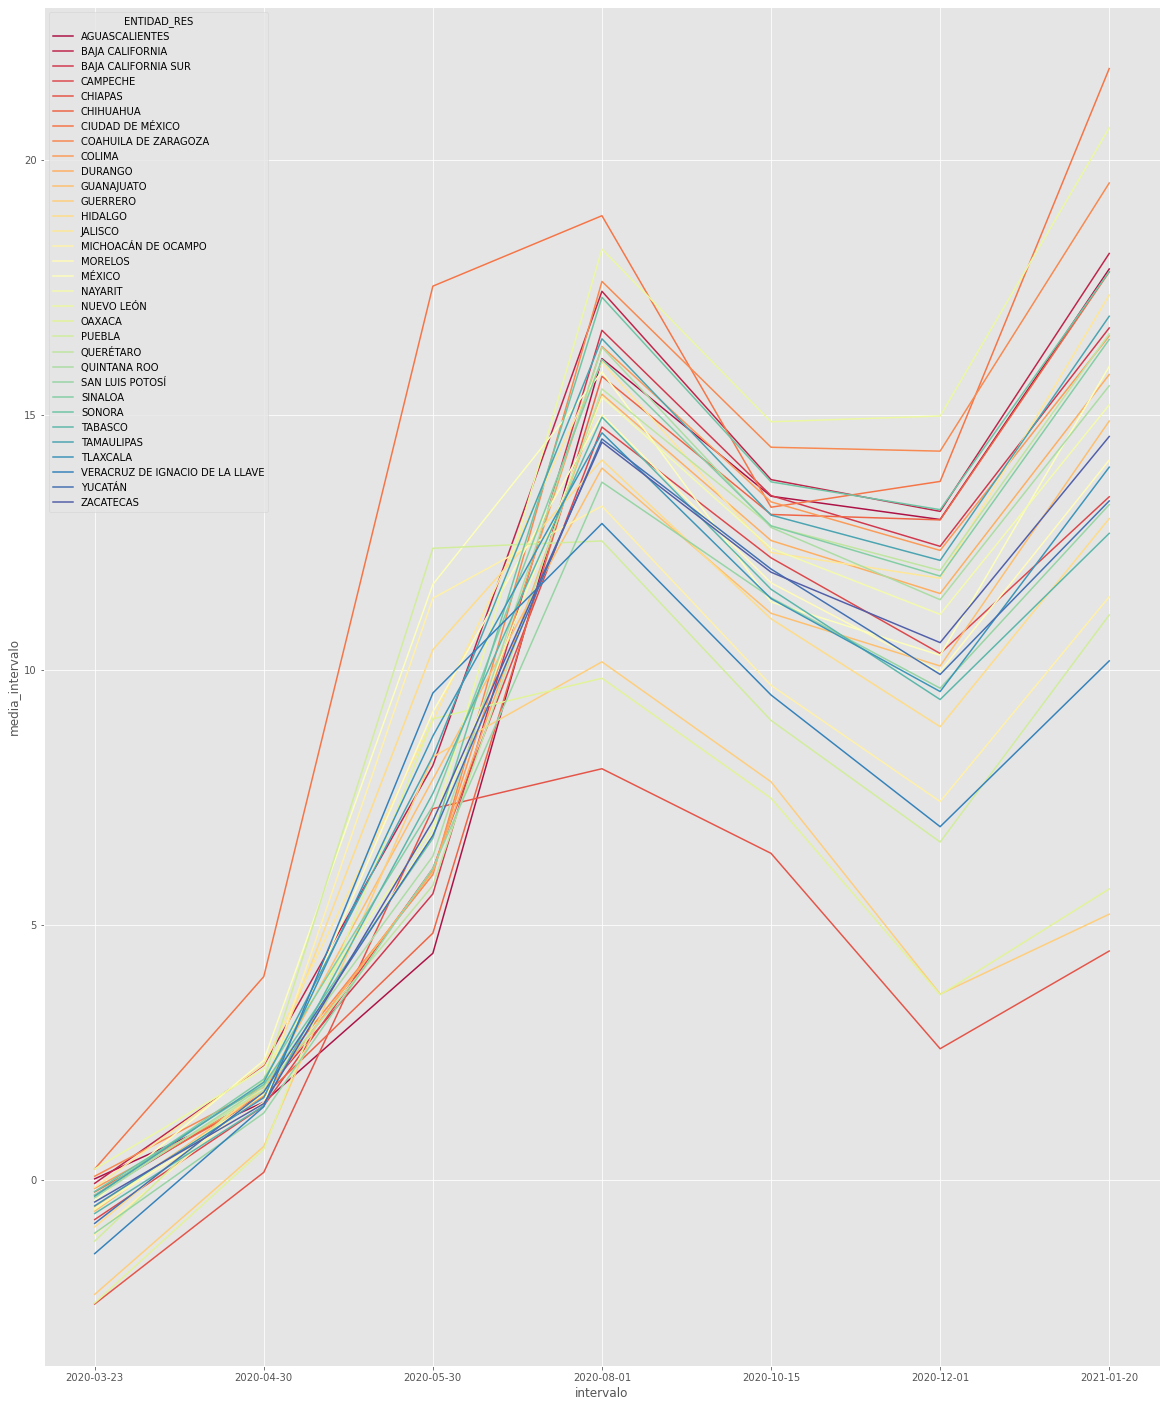

In [21]:
serie_momentos = serie[serie.FECHA_INGRESO.isin(fechas)]
entidad_momentos = (serie_momentos[["ENTIDAD_RES", "intervalo", "media_intervalo"]]
                    .groupby(["ENTIDAD_RES", "intervalo"])['media_intervalo']
                    .mean()
                    .reset_index()
                    )
fig, ax = plt.subplots(figsize=(20, 25))
sns.lineplot(data=entidad_momentos,
             x='intervalo', y=f'media_intervalo',
             hue='ENTIDAD_RES', palette='Spectral')

In [22]:
entidad_momentos_wide = (entidad_momentos
                       .pivot(index='ENTIDAD_RES', 
                              columns='intervalo', 
                              values='media_intervalo')
                      )
ranking_entidades = entidad_momentos_wide.rank(ascending=False)
new_cols = [c.strftime('%Y-%m-%d') if isinstance(c, datetime) else c for c in ranking_entidades.reset_index().columns]
parallel_data = ranking_entidades.reset_index()
parallel_data.columns = new_cols
parallel_data

ENTIDAD_RES  2020-03-23  2020-04-30  2020-05-30  \
0                    AGUASCALIENTES         4.0        23.0        32.0   
1                   BAJA CALIFORNIA         5.0         4.0        13.0   
2               BAJA CALIFORNIA SUR        10.0        17.0        30.0   
3                          CAMPECHE        23.0        27.0        25.0   
4                           CHIAPAS        32.0        32.0        17.0   
5                         CHIHUAHUA         9.0        21.0        31.0   
6                  CIUDAD DE MÉXICO         2.0         1.0         1.0   
7              COAHUILA DE ZARAGOZA         3.0        12.0        28.0   
8                            COLIMA         7.0        20.0        26.0   
9                           DURANGO        18.0        19.0        27.0   
10                       GUANAJUATO        21.0        14.0        14.0   
11                         GUERRERO        30.0        30.0        12.0   
12                          HIDALGO        25.0        10.0         5.0   
13                          JALISCO         6.0         3.0         9.0   
14              MICHOACÁN DE OCAMPO        27.0        15.0         4.0   
15                          MORELOS        19.0        24.0         7.0   
16                           MÉXICO        15.0         2.0         3.0   
17                          NAYARIT        20.0        18.0        20.0   
18                       NUEVO LEÓN         1.0         5.0        19.0   
19                           OAXACA        31.0        31.0         8.0   
20                           PUEBLA        28.0         7.0         2.0   
21                        QUERÉTARO        11.0        13.0        29.0   
22                     QUINTANA ROO        14.0        11.0        23.0   
23                  SAN LUIS POTOSÍ        26.0        29.0        24.0   
24                          SINALOA        12.0         6.0        16.0   
25                           SONORA         8.0         9.0        22.0   
26                          TABASCO        22.0        26.0        15.0   
27                       TAMAULIPAS        13.0         8.0        11.0   
28                         TLAXCALA        17.0        22.0        10.0   
29  VERACRUZ DE IGNACIO DE LA LLAVE        29.0        28.0         6.0   
30                          YUCATÁN        24.0        16.0        21.0   
31                        ZACATECAS        16.0        25.0        18.0   

    2020-08-01  2020-10-15  2020-12-01  2021-01-20  
0         10.0         6.0         6.0         5.0  
1          4.0         3.0         5.0         4.0  
2          6.0         5.0         8.0        10.0  
3         20.0        17.0        18.0        22.0  
4         32.0        32.0        32.0        32.0  
5         14.0         9.0         7.0         7.0  
6          1.0         8.0         3.0         1.0  
7          3.0         2.0         2.0         3.0  
8          8.0         7.0         9.0        12.0  
9         16.0        14.0        14.0        15.0  
10        25.0        25.0        20.0        18.0  
11        30.0        30.0        30.0        31.0  
12        24.0        26.0        26.0        25.0  
13        12.0        16.0        13.0         8.0  
14        27.0        27.0        27.0        27.0  
15        18.0        20.0        21.0        20.0  
16        13.0        24.0        19.0        14.0  
17        17.0        15.0        16.0        17.0  
18         2.0         1.0         1.0         2.0  
19        31.0        31.0        31.0        30.0  
20        29.0        29.0        29.0        28.0  
21        15.0        12.0        11.0        11.0  
22         9.0        13.0        15.0        16.0  
23        26.0        22.0        23.0        24.0  
24        11.0        11.0        12.0        13.0  
25         5.0         4.0         4.0         6.0  
26        19.0        21.0        25.0        26.0  
27         7.0        10.0        10.0         9.0  
28        2

In [23]:
fig, ax = plt.subplots(figsize=(20, 15))
p = pd.plotting.parallel_coordinates(parallel_data, "ENTIDAD_RES")
p.set_title("Evolución de la vulnerabilidad por Entidad promediada por intervalo")
plt.savefig('img/evolucion_vulnerabilidad_entidad_promedio.png', bbox_inches='tight')

## Evolución de la importancia de las variables

Para entender la dinámicva de la importancia de las variables vamos a hacer lo mismo que para la vulnerabilidad por estado.

Primero vamos a capturar las importancias _instantáneas_ en cada momento, después vamos a promediar los valores sobre cada intervalo.

Como el signo de los coeficientes sólo indica la dirección de rotación, vamos a tomar el valor absoluto para ver su evolución

In [190]:
dimensiones = pd.read_csv("datos/diccionario_variables_usadas.csv")
modelos_momentos = modelos_momentos.merge(dimensiones, left_on='caracteristica', right_on='campo').drop(columns=['campo', 'descriptor'])
modelos_momentos['coef'] = modelos_momentos['coef'].abs()
modelos_momentos

caracteristica      coef dia_ajuste modelo        dimension
0    total_camas_publicos  0.006227 2020-03-23    PLS      Health Care
1    total_camas_publicos  0.517644 2020-04-30    PLS      Health Care
2    total_camas_publicos  0.351522 2020-05-30    PLS      Health Care
3    total_camas_publicos  0.200276 2020-08-01    PLS      Health Care
4    total_camas_publicos  0.025143 2020-10-15    PLS      Health Care
..                    ...       ...        ...    ...              ...
268          pct_diabetes  0.260486 2020-05-30    PLS  Epidemiological
269          pct_diabetes  0.209910 2020-08-01    PLS  Epidemiological
270          pct_diabetes  0.072499 2020-10-15    PLS  Epidemiological
271          pct_diabetes  0.137086 2020-12-01    PLS  Epidemiological
272          pct_diabetes  0.121877 2021-01-20    PLS  Epidemiological

[273 rows x 5 columns]

In [191]:
modelos_momentos_wide = (modelos_momentos
                    .pivot(index=['caracteristica', 'dimension'],
                           columns='dia_ajuste',
                           values='coef')
                    )
ranking_variables = (modelos_momentos_wide
                     .groupby('dimension')
                     .rank(ascending=False)
                     .reset_index()
                     )
new_cols = [c.strftime('%Y-%m-%d') if isinstance(c, datetime)
            else c for c in ranking_variables.columns]
ranking_variables.columns = new_cols
ranking_variables

caracteristica            dimension  2020-03-23  2020-04-30  \
0                     an_2015        Socioeconomic         7.0         1.0   
1                     bi_2015        Socioeconomic         1.0        15.0   
2                   carencias        Socioeconomic        14.0         6.0   
3                  carencias3        Socioeconomic         5.0        18.0   
4                  consulto_1          Health Care         9.0         6.0   
5                  consultori          Health Care         3.0         7.0   
6                   farmacias          Health Care         5.0         1.0   
7                      ic_ali  Housing and hygiene         1.0         1.0   
8                   ic_asalud          Health Care         4.0         9.0   
9                       ic_cv  Housing and hygiene         3.0         4.0   
10                  ic_rezedu        Socioeconomic         4.0        17.0   
11                     ic_sbv  Housing and hygiene         2.0         7.0   
12                  ic_segsoc          Health Care         6.0         5.0   
13                   irs_2015        Socioeconomic        10.0        14.0   
14                  lmex_2015        Socioeconomic        13.0        11.0   
15                  ne614_015        Socioeconomic        18.0         4.0   
16                       npnv        Socioeconomic        11.0         9.0   
17               pct_diabetes      Epidemiological         1.0         1.0   
18           pct_hipertension      Epidemiological         2.0         3.0   
19               pct_obesidad      Epidemiological         3.0         2.0   
20                        plb        Socioeconomic         2.0        12.0   
21                       plbm        Socioeconomic         9.0         5.0   
22                    pobreza        Socioeconomic         3.0         8.0   
23                  pobreza_e        Socioeconomic         8.0        10.0   
24                  pobreza_m        Socioeconomic         6.0         7.0   
25        porc_carencia_salud        Socioeconomic        16.0         3.0   
26                    sins_15          Health Care         7.0         8.0   
27       total_camas_privados          Health Care         1.0         3.0   
28       total_camas_publicos          Health Care         2.0         2.0   
29  total_hospitales_publicos          Health Care         8.0         4.0   
30                   vna_2015  Housing and hygiene         5.0         6.0   
31                   vnd_2015  Housing and hygiene         4.0         8.0   
32                   vne_2015  Housing and hygiene         8.0         2.0   
33                   vnl_2015  Housing and hygiene         6.0         3.0   
34                   vnr_2015  Housing and hygiene         7.0         9.0   
35                   vns_2015  Housing and hygiene         9.0         5.0   
36                   vpt_2015        Socioeconomic        12.0        13.0   
37                    vul_car        Socioeconomic        17.0        16.0   
38                    vul_ing        Socioeconomic        15.0         2.0   

    2020-05-30  2020-08-01  2020-10-15  2020-12-01  2021-01-20  
0          3.0         9.0        12.0         9.0         3.0  
1          1.0         1.0        11.0        15.0         6.0  
2         10.0        13.0         5.0         8.0         5.0  
3         12.0        18.0         9.0         1.0         1.0  
4          4.0         7.0         9.0         1.0         5.0  
5          5.0         9.0         7.0         9.0         6.0  
6          1.0         8.0         2.0         5.0         2.0  
7          8.0         6.0         6.0         4.0         4.0  
8          2.0         6.0         5.0         3.0         7.0  
9          6.0         8.0         5.0         3.0         2.0  
10         2.0         8.0        13.0        14.0         9.0  
11         5.0         7.0         2.0         1.0         1.0  
12         9.0         1.0         1.0         2.

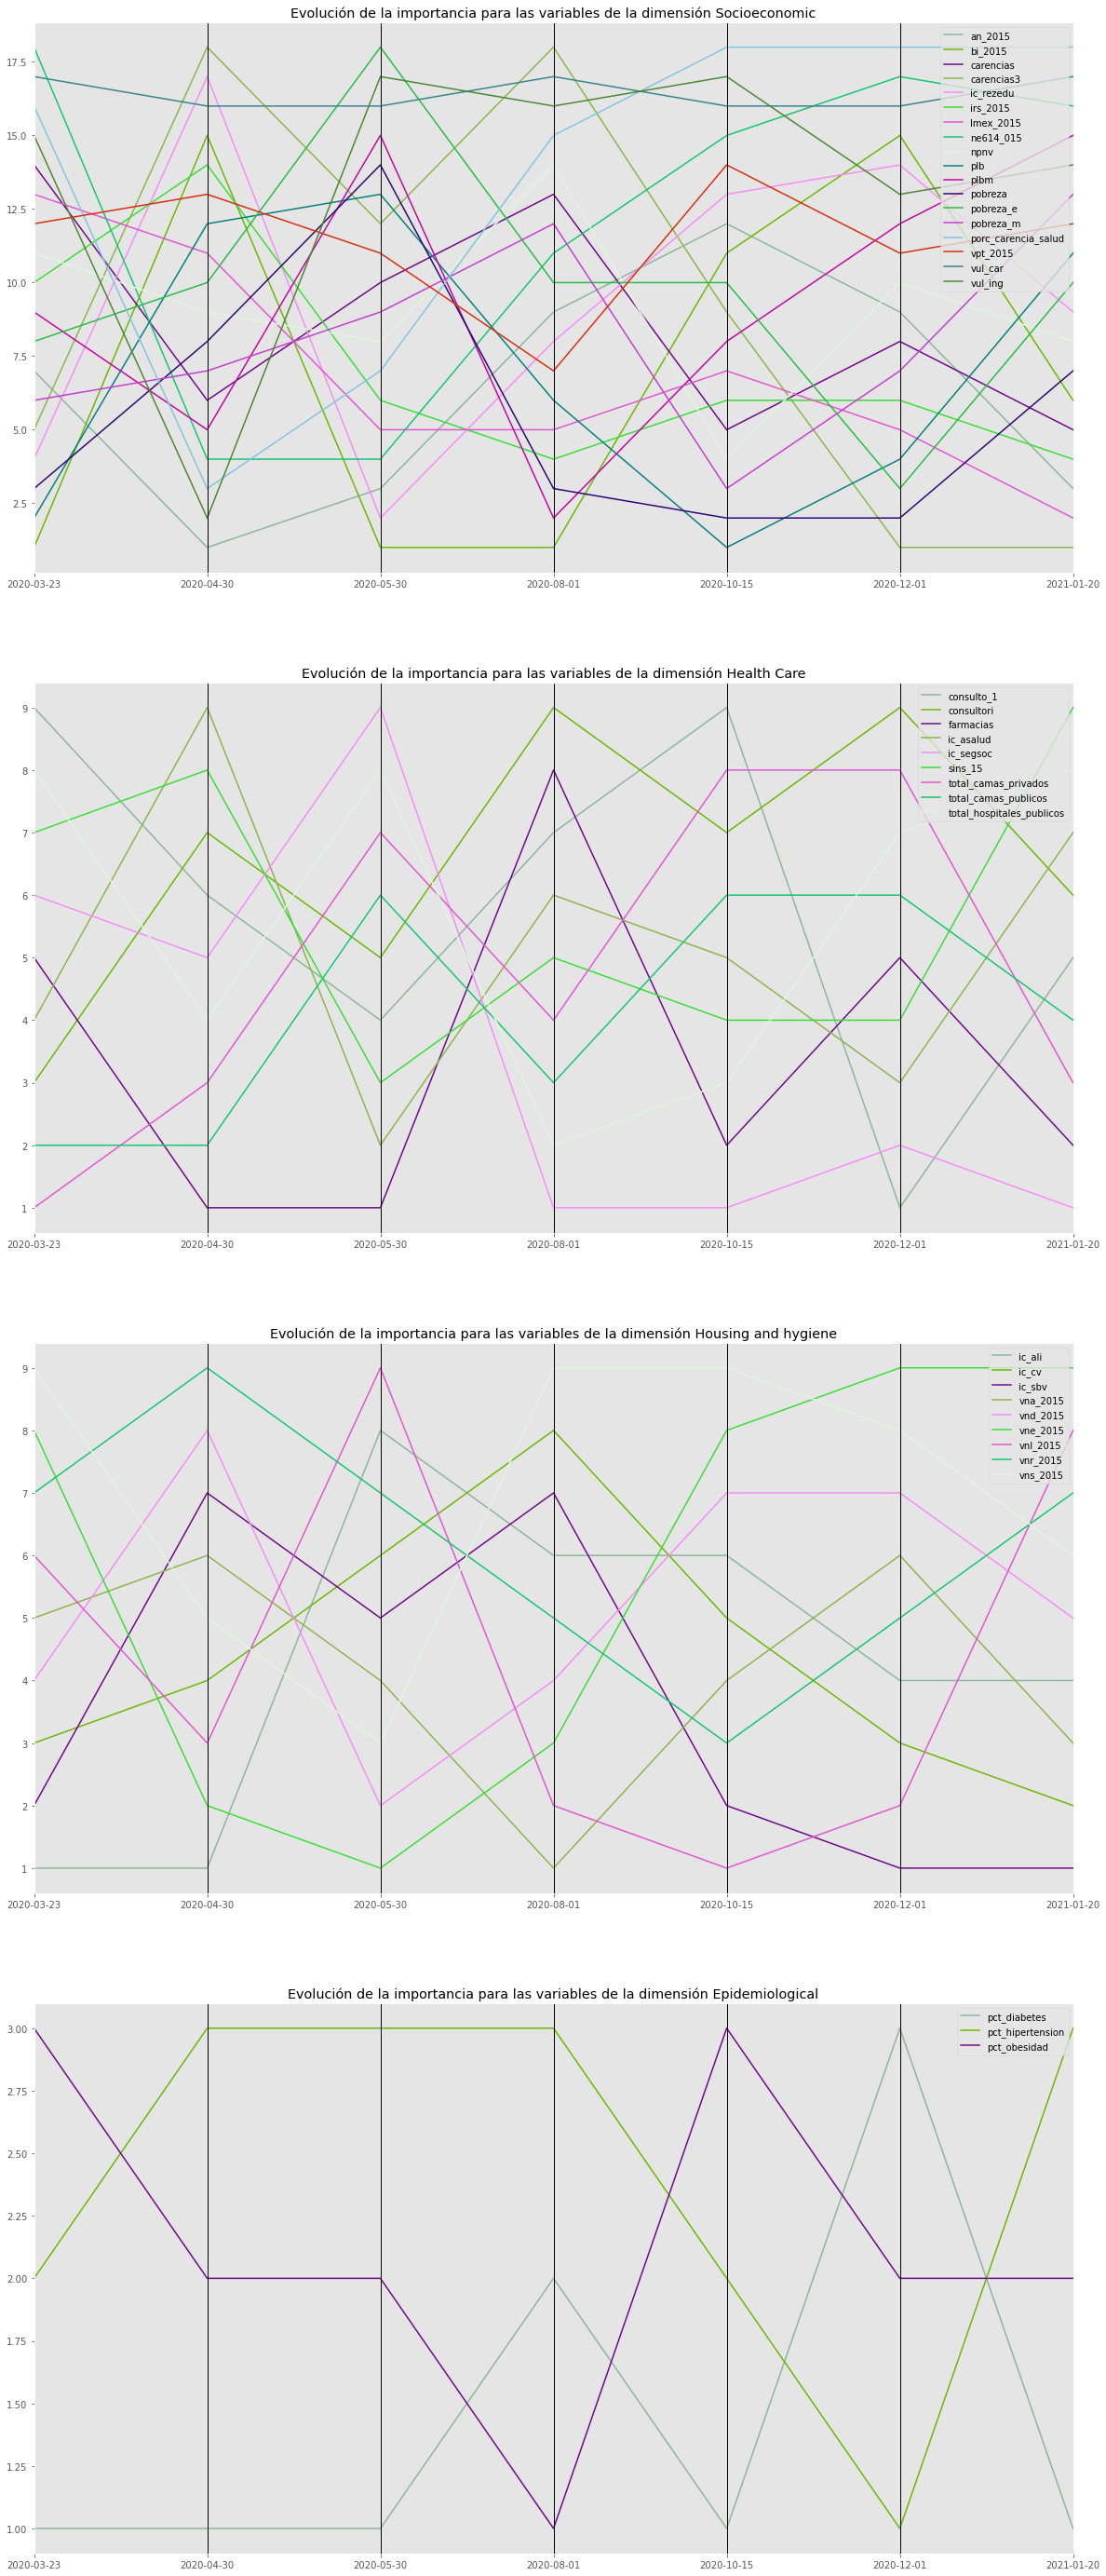

In [192]:
f, axes = plt.subplots(4,figsize=(20, 50))
lista_dimensiones = ranking_variables.dimension.unique()
for i, ax in enumerate(axes):
    datos = ranking_variables[ranking_variables.dimension == lista_dimensiones[i]]
    f = pd.plotting.parallel_coordinates(datos.drop(columns="dimension"),
                                         "caracteristica",
                                         ax=ax)
    f.set_title(f'Evolución de la importancia para las variables de la dimensión {lista_dimensiones[i]}')
plt.savefig('img/evolucion_caracteristicas_por_dimension.png', bbox_inches='tight')

### Evolución de la importancia promedio
Ahora lo mismo pero promediamos los valores por cada periodo

In [193]:
for i, fecha in enumerate(fechas):
    if i == 0:
        modelos.loc[modelos.dia_ajuste <= fecha, 'intervalo'] = fecha.strftime('%Y-%m-%d')
    else:
        modelos.loc[(modelos.dia_ajuste > fechas[i-1]) & (modelos.dia_ajuste <= fecha), 'intervalo'] = fecha.strftime('%Y-%m-%d') 
modelos['media_intervalo'] = modelos.groupby(['intervalo', 'caracteristica'])['coef'].transform('mean')
modelos

caracteristica      coef dia_ajuste modelo   intervalo  \
0      total_camas_publicos  0.006642 2020-03-15    PLS  2020-03-23   
1                 pobreza_m -0.012927 2020-03-15    PLS  2020-03-23   
2                 lmex_2015  0.008947 2020-03-15    PLS  2020-03-23   
3       porc_carencia_salud -0.012214 2020-03-15    PLS  2020-03-23   
4                   pobreza -0.012783 2020-03-15    PLS  2020-03-23   
...                     ...       ...        ...    ...         ...   
14035               vul_ing  0.099763 2021-02-28    PLS  2021-03-08   
14036             ic_asalud  0.049166 2021-02-28    PLS  2021-03-08   
14037          pct_obesidad -0.071438 2021-02-28    PLS  2021-03-08   
14038  total_camas_privados -0.053646 2021-02-28    PLS  2021-03-08   
14039          pct_diabetes  0.060248 2021-02-28    PLS  2021-03-08   

       media_intervalo  
0            -0.001650  
1            -0.010229  
2             0.007721  
3            -0.008218  
4            -0.010288  
...                ...  
14035         0.169959  
14036         0.030041  
14037        -0.073428  
14038        -0.085438  
14039         0.077386  

[14040 rows x 6 columns]

In [194]:
modelos_momentos = modelos[modelos.dia_ajuste.isin(fechas)]
modelos_momentos = modelos_momentos.merge(dimensiones, left_on='caracteristica', right_on='campo').drop(columns=['campo', 'descriptor'])
modelos_momentos = modelos_momentos.drop(columns='coef')
modelos_momentos_wide = (modelos_momentos
                    .pivot(index=['caracteristica', 'dimension'],
                           columns='dia_ajuste',
                           values='media_intervalo')
                    )
ranking_variables = (modelos_momentos_wide
                     .groupby('dimension')
                     .rank(ascending=False)
                     .reset_index()
                     )
new_cols = [c.strftime('%Y-%m-%d') if isinstance(c, datetime)
            else c for c in ranking_variables.columns]
ranking_variables.columns = new_cols
ranking_variables

caracteristica            dimension  2020-03-23  2020-04-30  \
0                     an_2015        Socioeconomic        14.0         3.0   
1                     bi_2015        Socioeconomic        12.0         7.0   
2                   carencias        Socioeconomic         4.0         2.0   
3                  carencias3        Socioeconomic        13.0        11.0   
4                  consulto_1          Health Care         2.0         2.0   
5                  consultori          Health Care         7.0         5.0   
6                   farmacias          Health Care         4.0         7.0   
7                      ic_ali  Housing and hygiene         9.0         9.0   
8                   ic_asalud          Health Care         9.0         4.0   
9                       ic_cv  Housing and hygiene         6.0         4.0   
10                  ic_rezedu        Socioeconomic        10.0        12.0   
11                     ic_sbv  Housing and hygiene         7.0         7.0   
12                  ic_segsoc          Health Care         6.0         3.0   
13                   irs_2015        Socioeconomic        15.0         5.0   
14                  lmex_2015        Socioeconomic         1.0         4.0   
15                  ne614_015        Socioeconomic         3.0        15.0   
16                       npnv        Socioeconomic         8.0         6.0   
17               pct_diabetes      Epidemiological         2.0         1.0   
18           pct_hipertension      Epidemiological         1.0         3.0   
19               pct_obesidad      Epidemiological         3.0         2.0   
20                        plb        Socioeconomic        17.0        13.0   
21                       plbm        Socioeconomic        11.0        10.0   
22                    pobreza        Socioeconomic        18.0         9.0   
23                  pobreza_e        Socioeconomic         9.0        14.0   
24                  pobreza_m        Socioeconomic        16.0         8.0   
25        porc_carencia_salud        Socioeconomic         7.0        17.0   
26                    sins_15          Health Care         8.0         1.0   
27       total_camas_privados          Health Care         5.0         9.0   
28       total_camas_publicos          Health Care         3.0         8.0   
29  total_hospitales_publicos          Health Care         1.0         6.0   
30                   vna_2015  Housing and hygiene         5.0         8.0   
31                   vnd_2015  Housing and hygiene         3.0         5.0   
32                   vne_2015  Housing and hygiene         2.0         6.0   
33                   vnl_2015  Housing and hygiene         8.0         2.0   
34                   vnr_2015  Housing and hygiene         4.0         3.0   
35                   vns_2015  Housing and hygiene         1.0         1.0   
36                   vpt_2015        Socioeconomic         5.0        16.0   
37                    vul_car        Socioeconomic         2.0         1.0   
38                    vul_ing        Socioeconomic         6.0        18.0   

    2020-05-30  2020-08-01  2020-10-15  2020-12-01  2021-01-20  
0         11.0        16.0        10.0        10.0        15.0  
1         16.0        18.0         8.0         6.0        11.0  
2          4.0         7.0        12.0        15.0        17.0  
3         10.0         5.0         6.0        18.0        18.0  
4          4.0         8.0         4.0         5.0         4.0  
5          6.0         6.0         5.0         3.0         5.0  
6          9.0         9.0         6.0         6.0         8.0  
7          7.0         2.0         7.0         5.0         6.0  
8          1.0         2.0         7.0         7.0         3.0  
9          1.0         1.0         3.0         7.0         8.0  
10        17.0        17.0         4.0         7.0        13.0  
11         6.0         5.0         5.0         8.0         9.0  
12         3.0         7.0         9.0         9.

In [195]:
f, axes = plt.subplots(4,figsize=(20, 50))
lista_dimensiones = ranking_variables.dimension.unique()
for i, ax in enumerate(axes):
    datos = ranking_variables[ranking_variables.dimension == lista_dimensiones[i]]
    f = pd.plotting.parallel_coordinates(datos.drop(columns="dimension"),
                                         "caracteristica",
                                         ax=ax)
    f.set_title(f'Evolución de la importancia para las variables de la dimensión {lista_dimensiones[i]}')
plt.savefig('img/evolucion_caracteristicas_por_dimension_promedio.png', bbox_inches='tight')